# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Alexis Perumal, 12/15/19
# UCSD Data Science Bootcamp, HW #6 Python API, WeatherPy project

# Shell commands used to diagnose why the api_keys.py files wasn't being read correctly.
# !conda list
# !sys path
# !pwd
# !ls
# !cat api_keys.py

# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import pprint
import datetime as dt
from scipy import stats

from api_keys import open_weather_key  # Make sure the key is not included in github repo!

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy # Anaconda doesn't have it so do: "pip install citypy" in the env.
# To get this environment to work in Jupyter Notebook: https://janakiev.com/blog/jupyter-virtual-envs/
# Better:
# conda install nb_conda
# From https://stackoverflow.com/questions/37085665/in-which-conda-environment-is-jupyter-executing/39070588


import shelve  # Use to store data across instance runs so we don't have to actually hit the
                # Web everytime. This is helpful for dev & debug.


# Constants

# Data Source:
#   0: Fresh random numbers (lat&long), and pull weather from the web, but don't archive results.
#   1: Fresh random numbers & real time pull, with archival in the shelf file.
#   2: Retrieve city list and weather from the shelf file. No real time Web API query.
DATA_FRESHNESS = 1

SHELF_FNAME = "cities_and_weather"

if DATA_FRESHNESS == 1 or DATA_FRESHNESS == 2:
    shelf_file = shelve.open(SHELF_FNAME)

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)
print("OK, ready to go!")
%pwd
print(shelf_file)
!pwd
pprint.pprint(shelf_file)
# print(shelf_file['cities'])

OK, ready to go!
/Users/aperumal/OneDrive/Personal/UCSD_Data_Science_Bootcamp/Homework/2019-12-15_HW6_Python_API/python-api-challenge


## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
def build_city_list():
    lat_lngs = []
    cities = []

    cities.append('bogus_city') # Put a bugus city name at the front to ensure the code works
                                # well when there isn't a match on the city search.

    # Create a set of random lat and lng combinations
    lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
    lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
    lat_lngs = zip(lats, lngs)

    # Identify nearest city for each lat, lng combination
    for lat_lng in lat_lngs:
        city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name

        # If the city is unique, then add it to a our cities list
        if city not in cities:
            cities.append(city)

    # Print the city count to confirm sufficient count
    len(cities)
    return cities

if DATA_FRESHNESS == 0 or DATA_FRESHNESS == 1:  # Generate the data
    cities = build_city_list()
    if DATA_FRESHNESS == 1: # Archive the city list in the shelf file.
        shelf_file['cities'] = cities
        # shelf_file.close()
else:  # Get the data from the shelf file.
    print("Retrieving the data from the shelf file.")
    cities = shelf_file['cities']
    
len(cities)
# shelf_file.close()
# cities

622

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
# Setup openweather base URL with everything but the city name.
ow_base_url = "http://api.openweathermap.org/data/2.5/weather?"+ "appid=" + open_weather_key + "&units=metric" + "&q="
city = "Poway"

query_url = ow_base_url + city

In [4]:
response = requests.get(query_url)
weather = response.json()

temp = weather['main']['temp']
lat = weather['coord']['lat']
timestamp = weather['dt']
date_time = dt.datetime.utcfromtimestamp(timestamp)
print(f"  {city}: temp={temp}, lat={lat}, Date/Time={date_time}")
pprint.pprint(weather)

  Poway: temp=6.53, lat=32.96, Date/Time=2019-12-28 06:42:24
{'base': 'stations',
 'clouds': {'all': 1},
 'cod': 200,
 'coord': {'lat': 32.96, 'lon': -117.04},
 'dt': 1577515344,
 'id': 5384690,
 'main': {'feels_like': 5.01,
          'humidity': 93,
          'pressure': 1016,
          'temp': 6.53,
          'temp_max': 11,
          'temp_min': -0.56},
 'name': 'Poway',
 'sys': {'country': 'US',
         'id': 4052,
         'sunrise': 1577458173,
         'sunset': 1577494116,
         'type': 1},
 'timezone': -28800,
 'visibility': 16093,
 'weather': [{'description': 'clear sky',
              'icon': '01n',
              'id': 800,
              'main': 'Clear'}],
 'wind': {'deg': 77, 'speed': 0.71}}


In [5]:
def get_weather(cities):  
    # Setup openweather base URL with everything but the city name.
    ow_base_url = "http://api.openweathermap.org/data/2.5/weather?"+ "appid=" + open_weather_key + "&units=metric" + "&q="

    set = 1
    i = 1
    found_cities = []
    country_list = []
    temp_list = []
    humidity_list = []
    cloudiness_list = []
    windspeed_list = []
    lat_list = []
    long_list = []
    time_list = []
    time_sunrise_list = []
    time_sunset_list = []
    timezone_offset_list = []
    for city in cities:
        # url = query_base_url+city
        response = requests.get(ow_base_url+city)
        if response.status_code == 404:
            print("City not found (404 Error). Skipping...")
        else:
            print(f"Processing Record {i} of Set {set} | {city}")
            found_cities.append(city)
            weather = response.json()
            #pprint.pprint(weather)
            country = weather['sys']['country']
            temp = weather['main']['temp']
            humidity = weather['main']['humidity']
            cloudiness = weather['clouds']['all']
            windspeed = weather['wind']['speed']
            lat = weather['coord']['lat']
            long = weather['coord']['lon']
            date_time = dt.datetime.utcfromtimestamp(weather['dt'])
#             time_sunrise = weather['sys']['sunrise']
#             time_sunset = weather['sys']['sunset']
#             timezone_offset = weather['timezone']
            # print(f"  {city}: temp={temp}, lat={lat}")
            
            country_list.append(country)
            temp_list.append(temp)
            humidity_list.append(humidity)
            cloudiness_list.append(cloudiness)
            windspeed_list.append(windspeed)
            lat_list.append(lat)
            long_list.append(long)
            time_list.append(date_time)
#             time_sunrise_list.append(time_sunrise)
#             time_sunset_list.append(time_sunset)
#             timezone_offset_list.append(timezone_offset)
            
            print(f"City: {city}")
            time.sleep(0.01)
            i+=1
            
#             if i == 30:  # break early for debugging
#                 break

#
#     weather = pd.DataFrame({'City':found_cities, 'Country':country_list, 'Temp': temp_list, 'Humidity':humidity_list, 'Cloud %':cloudiness_list,
#                             'Windspeed':windspeed_list, 'Lat':lat_list, 'Long':long_list, 'Time':time_list,
#                             'Sunrise':time_sunrise_list, 'Sunset':time_sunset_list, 'TZ offset':timezone_offset_list})
    weather = pd.DataFrame({'City':found_cities, 'Country':country_list, 'Temp': temp_list, 'Humidity':humidity_list, 'Cloud %':cloudiness_list,
                            'Windspeed':windspeed_list, 'Lat':lat_list, 'Long':long_list, 'Time':time_list})
    return weather

#   0: Fresh random numbers (lat&long), and pull weather from the web, but don't archive results.
#   1: Fresh random numbers & real time pull, with archival in the shelf file.
#   2: Retrieve city list and weather from the shelf file. No real time Web API query.

print(len(cities))

if DATA_FRESHNESS == 0 or DATA_FRESHNESS == 1: # Retrieve Weather Data from API
    weather = get_weather(cities)
    if DATA_FRESHNESS == 1: # Archive the city list in the shelf file.
        shelf_file['weather'] = weather
        shelf_file.close()
else:  # Get the data from the shelf file.
    print("Retrieving the data from the shelf file.")
    weather = shelf_file['weather']
    shelf_file.close()
    

print(len(weather['Temp']))




622
City not found (404 Error). Skipping...
Processing Record 1 of Set 1 | mar del plata
City: mar del plata
Processing Record 2 of Set 1 | cabo san lucas
City: cabo san lucas
Processing Record 3 of Set 1 | aracuai
City: aracuai
Processing Record 4 of Set 1 | muisne
City: muisne
Processing Record 5 of Set 1 | jamestown
City: jamestown
Processing Record 6 of Set 1 | kirgiz-miyaki
City: kirgiz-miyaki
Processing Record 7 of Set 1 | ipixuna
City: ipixuna
Processing Record 8 of Set 1 | smirnykh
City: smirnykh
Processing Record 9 of Set 1 | ushuaia
City: ushuaia
Processing Record 10 of Set 1 | barrow
City: barrow
Processing Record 11 of Set 1 | hasaki
City: hasaki
Processing Record 12 of Set 1 | denpasar
City: denpasar
Processing Record 13 of Set 1 | fiumicino
City: fiumicino
Processing Record 14 of Set 1 | punta arenas
City: punta arenas
Processing Record 15 of Set 1 | omboue
City: omboue
Processing Record 16 of Set 1 | rikitea
City: rikitea
Processing Record 17 of Set 1 | alofi
City: alofi

Processing Record 137 of Set 1 | bambanglipuro
City: bambanglipuro
Processing Record 138 of Set 1 | nhamunda
City: nhamunda
Processing Record 139 of Set 1 | tabou
City: tabou
Processing Record 140 of Set 1 | garissa
City: garissa
Processing Record 141 of Set 1 | new norfolk
City: new norfolk
Processing Record 142 of Set 1 | bahia blanca
City: bahia blanca
City not found (404 Error). Skipping...
City not found (404 Error). Skipping...
Processing Record 143 of Set 1 | barcelos
City: barcelos
Processing Record 144 of Set 1 | lampazos de naranjo
City: lampazos de naranjo
Processing Record 145 of Set 1 | san quintin
City: san quintin
City not found (404 Error). Skipping...
Processing Record 146 of Set 1 | dingle
City: dingle
Processing Record 147 of Set 1 | thompson
City: thompson
Processing Record 148 of Set 1 | avera
City: avera
Processing Record 149 of Set 1 | qaanaaq
City: qaanaaq
Processing Record 150 of Set 1 | kindu
City: kindu
Processing Record 151 of Set 1 | poum
City: poum
City no

Processing Record 269 of Set 1 | minden
City: minden
Processing Record 270 of Set 1 | buta
City: buta
Processing Record 271 of Set 1 | saint pete beach
City: saint pete beach
Processing Record 272 of Set 1 | kobryn
City: kobryn
Processing Record 273 of Set 1 | zyryanka
City: zyryanka
Processing Record 274 of Set 1 | kharp
City: kharp
Processing Record 275 of Set 1 | basoko
City: basoko
Processing Record 276 of Set 1 | grindavik
City: grindavik
Processing Record 277 of Set 1 | waingapu
City: waingapu
Processing Record 278 of Set 1 | husavik
City: husavik
Processing Record 279 of Set 1 | zyryanskoye
City: zyryanskoye
Processing Record 280 of Set 1 | lianran
City: lianran
Processing Record 281 of Set 1 | karpathos
City: karpathos
Processing Record 282 of Set 1 | te anau
City: te anau
Processing Record 283 of Set 1 | juneau
City: juneau
Processing Record 284 of Set 1 | balikpapan
City: balikpapan
Processing Record 285 of Set 1 | thaton
City: thaton
Processing Record 286 of Set 1 | ulaangom

Processing Record 401 of Set 1 | vologda
City: vologda
Processing Record 402 of Set 1 | millerovo
City: millerovo
Processing Record 403 of Set 1 | morant bay
City: morant bay
Processing Record 404 of Set 1 | acapulco
City: acapulco
Processing Record 405 of Set 1 | turbat
City: turbat
Processing Record 406 of Set 1 | tygda
City: tygda
City not found (404 Error). Skipping...
City not found (404 Error). Skipping...
Processing Record 407 of Set 1 | airai
City: airai
Processing Record 408 of Set 1 | jacqueville
City: jacqueville
Processing Record 409 of Set 1 | ambulu
City: ambulu
Processing Record 410 of Set 1 | trebisov
City: trebisov
Processing Record 411 of Set 1 | santa cruz
City: santa cruz
Processing Record 412 of Set 1 | coquimbo
City: coquimbo
Processing Record 413 of Set 1 | chara
City: chara
Processing Record 414 of Set 1 | copiapo
City: copiapo
Processing Record 415 of Set 1 | saint-pierre
City: saint-pierre
Processing Record 416 of Set 1 | riyadh
City: riyadh
City not found (40

City not found (404 Error). Skipping...
Processing Record 534 of Set 1 | fuling
City: fuling
Processing Record 535 of Set 1 | portland
City: portland
Processing Record 536 of Set 1 | jacmel
City: jacmel
Processing Record 537 of Set 1 | ewo
City: ewo
City not found (404 Error). Skipping...
Processing Record 538 of Set 1 | lavrentiya
City: lavrentiya
Processing Record 539 of Set 1 | sao joao da barra
City: sao joao da barra
City not found (404 Error). Skipping...
Processing Record 540 of Set 1 | areosa
City: areosa
Processing Record 541 of Set 1 | sayat
City: sayat
Processing Record 542 of Set 1 | wlodawa
City: wlodawa
Processing Record 543 of Set 1 | innisfail
City: innisfail
Processing Record 544 of Set 1 | obo
City: obo
Processing Record 545 of Set 1 | ulladulla
City: ulladulla
Processing Record 546 of Set 1 | yarega
City: yarega
City not found (404 Error). Skipping...
Processing Record 547 of Set 1 | caxito
City: caxito
Processing Record 548 of Set 1 | hemsedal
City: hemsedal
Process

In [18]:
pprint.pprint(weather)

               City Country   Temp  Humidity  Cloud %  Windspeed    Lat  \
0     mar del plata      AR  13.91        38       14      10.68 -46.43   
1    cabo san lucas      MX  17.52        72       75       1.50  22.89   
2           aracuai      BR  18.88        94       18       1.40 -16.85   
3            muisne      EC  24.08        89       84       2.79   0.61   
4         jamestown      AU  37.08        15       80       4.85 -33.21   
..              ...     ...    ...       ...      ...        ...    ...   
558           paita      PE  22.38        77      100       2.53  -5.09   
559         kuusamo      FI -24.00        83       16       0.50  65.96   
560          obuasi      GH  22.14        96        0       0.10   6.21   
561          guilin      CN  13.00        50       90       1.00  25.28   
562        rotifunk      SL  22.24        96        0       0.69   8.23   

       Long                Time  
0    -67.52 2019-12-28 06:45:04  
1   -109.91 2019-12-28 06:41:11

In [19]:
date_str = str(weather.iloc[0]['Time'])[:10]
year = date_str[:4]
month = date_str[5:7]
day = date_str[-2:]
extract_date_str = f"{month}/{day}/{year}"
extract_date_str

'12/28/2019'

Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1 | lompoc
Processing Record 2 of Set 1 | klaksvik
Processing Record 3 of Set 1 | bisignano
Processing Record 4 of Set 1 | bengkulu
City not found. Skipping...
Processing Record 5 of Set 1 | hilo
Processing Record 6 of Set 1 | rikitea
Processing Record 7 of Set 1 | ahipara
Processing Record 8 of Set 1 | lebu
Processing Record 9 of Set 1 | hamilton
Processing Record 10 of Set 1 | castro
Processing Record 11 of Set 1 | ashland
Processing Record 12 of Set 1 | ushuaia
Processing Record 13 of Set 1 | haines junction
Processing Record 14 of Set 1 | punta arenas
Processing Record 15 of Set 1 | salalah
Processing Record 16 of Set 1 | port macquarie
Processing Record 17 of Set 1 | mataura
Processing Record 18 of Set 1 | saint-philippe
Processing Record 19 of Set 1 | kaitangata
Processing Record 20 of Set 1 | souillac
Processing Record 21 of Set 1 | srednekolymsk
Processing Record 22 of Set 1 | busselton
Proce

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [20]:
weather.to_csv("weather.csv")
print(len(weather))
weather.head()

563


,City,Country,Temp,Humidity,Cloud %,Windspeed,Lat,Long,Time
0,mar del plata,AR,13.91,38,14,10.68,-46.43,-67.52,2019-12-28 06:45:04
1,cabo san lucas,MX,17.52,72,75,1.50,22.89,-109.91,2019-12-28 06:41:11
2,aracuai,BR,18.88,94,18,1.40,-16.85,-42.07,2019-12-28 06:43:21
3,muisne,EC,24.08,89,84,2.79,0.61,-80.02,2019-12-28 06:45:05
4,jamestown,AU,37.08,15,80,4.85,-33.21,138.60,2019-12-28 06:45:05


City          547
Cloudiness    547
Country       547
Date          547
Humidity      547
Lat           547
Lng           547
Max Temp      547
Wind Speed    547
dtype: int64

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,lompoc,1,US,1534984500,44,34.64,-120.46,77.00,11.41
1,klaksvik,92,FO,1534983600,100,62.23,-6.59,50.00,13.87
2,bisignano,0,IT,1534981800,88,39.50,16.27,66.20,5.82
3,hilo,90,US,1534984860,90,19.71,-155.08,77.00,8.05
4,rikitea,8,PF,1534986579,100,-23.12,-134.97,69.58,19.71


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

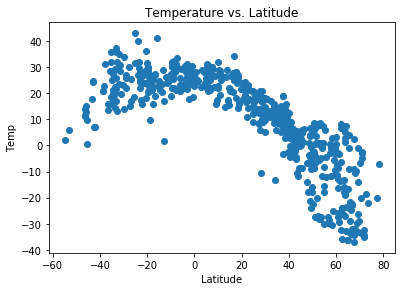

In [21]:
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

axes.set_xlabel('Latitude')
axes.set_ylabel('Temp')
axes.set_title('Temperature vs. Latitude')
axes.scatter(weather['Lat'], weather['Temp'])

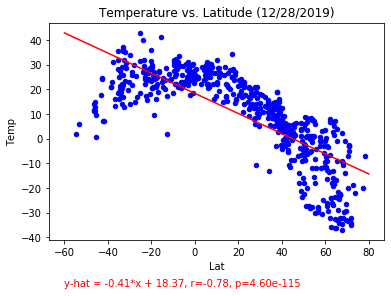

In [25]:
slope, int, r_val, p_val, se = stats.linregress(weather['Lat'], weather['Temp'])
weather.plot.scatter(x='Lat', y='Temp', color='Blue',
                     title=f"Temperature vs. Latitude ({extract_date_str})")
x = [-60, 80]
y = [int + slope * n for n in x] 
plt.plot(x, y, color='Red')
plt.text(-60, -60, f"y-hat = {slope:0.2f}*x + {int:0.2f}, r={r_val:0.2f}, p={p_val:0.2e}", color="Red")
plt.savefig('temp-vs-lat.png', dpi=100)
plt.show()

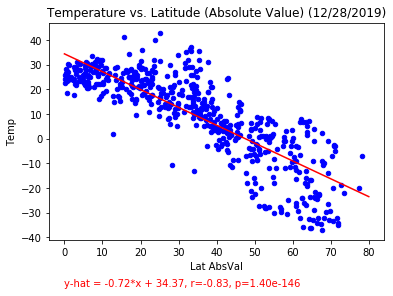

In [26]:
weather['Lat AbsVal'] = weather['Lat'].abs()
slope, int, r_val, p_val, se = stats.linregress(weather['Lat AbsVal'], weather['Temp'])
weather.plot.scatter(x='Lat AbsVal', y='Temp', color='Blue',
                     title=f"Temperature vs. Latitude (Absolute Value) ({extract_date_str})")
x = [0, 80]
y = [int + slope * n for n in x] 
plt.plot(x, y, color='Red')
plt.text(0, -60, f"y-hat = {slope:0.2f}*x + {int:0.2f}, r={r_val:0.2f}, p={p_val:0.2e}", color="Red")
plt.savefig('temp-vs-lat-abs.png', dpi=100)
plt.show()

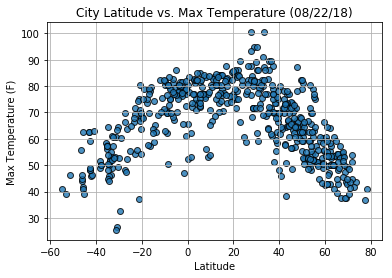

#### Latitude vs. Humidity Plot

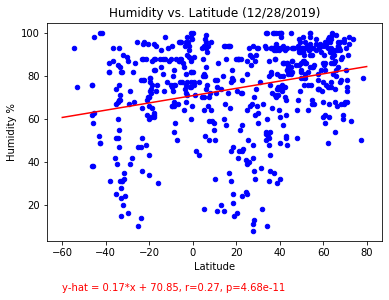

In [28]:
slope, int, r_val, p_val, se = stats.linregress(weather['Lat'], weather['Humidity'])
weather.plot.scatter(x='Lat', y='Humidity', color='Blue',
                     title=f"Humidity vs. Latitude ({extract_date_str})")
x = [-60, 80]
y = [int + slope * n for n in x] 
plt.plot(x, y, color='Red')
plt.xlabel('Latitude')
plt.ylabel('Humidity %')
plt.text(-60, -20, f"y-hat = {slope:0.2f}*x + {int:0.2f}, r={r_val:0.2f}, p={p_val:0.2e}", color="Red")
plt.savefig('Humidity-vs-lat.png', dpi=100)
plt.show()

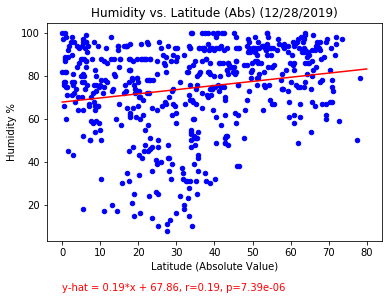

In [30]:
slope, int, r_val, p_val, se = stats.linregress(weather['Lat AbsVal'], weather['Humidity'])
weather.plot.scatter(x='Lat AbsVal', y='Humidity', color='Blue',
                     title=f"Humidity vs. Latitude (Abs) ({extract_date_str})")
x = [0, 80]
y = [int + slope * n for n in x] 
plt.plot(x, y, color='Red')
plt.xlabel('Latitude (Absolute Value)')
plt.ylabel('Humidity %')
plt.text(0, -20, f"y-hat = {slope:0.2f}*x + {int:0.2f}, r={r_val:0.2f}, p={p_val:0.2e}", color="Red")
plt.savefig('Humidity-vs-lat-abs.png', dpi=100)
plt.show()

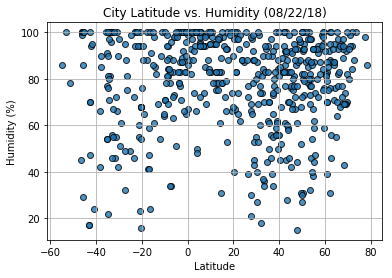

#### Latitude vs. Cloudiness Plot

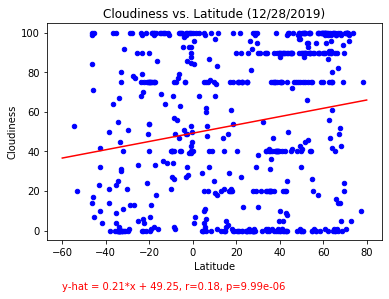

In [31]:
slope, int, r_val, p_val, se = stats.linregress(weather['Lat'], weather['Cloud %'])
weather.plot.scatter(x='Lat', y='Cloud %', color='Blue',
                     title=f"Cloudiness vs. Latitude ({extract_date_str})")
x = [-60, 80]
y = [int + slope * n for n in x] 
plt.plot(x, y, color='Red')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness')
plt.text(-60, -30, f"y-hat = {slope:0.2f}*x + {int:0.2f}, r={r_val:0.2f}, p={p_val:0.2e}", color="Red")
plt.savefig('Cloudiness-vs-lat.png', dpi=100)
plt.show()

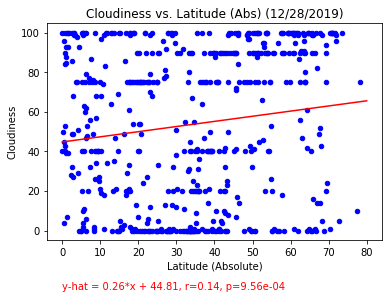

In [32]:
slope, int, r_val, p_val, se = stats.linregress(weather['Lat AbsVal'], weather['Cloud %'])
weather.plot.scatter(x='Lat AbsVal', y='Cloud %', color='Blue',
                     title=f"Cloudiness vs. Latitude (Abs) ({extract_date_str})")
x = [0, 80]
y = [int + slope * n for n in x] 
plt.plot(x, y, color='Red')
plt.xlabel('Latitude (Absolute)')
plt.ylabel('Cloudiness')
plt.text(0, -30, f"y-hat = {slope:0.2f}*x + {int:0.2f}, r={r_val:0.2f}, p={p_val:0.2e}", color="Red")
plt.savefig('Cloudiness-vs-lat-abs.png', dpi=100)
plt.show()

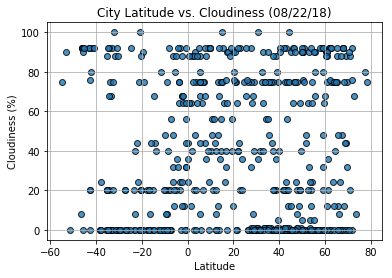

#### Latitude vs. Wind Speed Plot

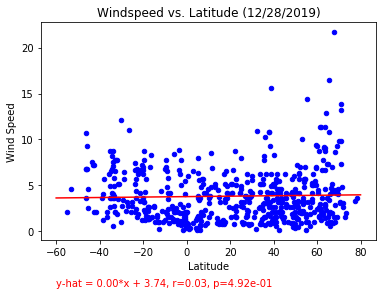

In [34]:
slope, int, r_val, p_val, se = stats.linregress(weather['Lat'], weather['Windspeed'])
weather.plot.scatter(x='Lat', y='Windspeed', color='Blue',
                     title=f"Windspeed vs. Latitude ({extract_date_str})")
x = [-60, 80]
y = [int + slope * n for n in x] 
plt.plot(x, y, color='Red')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed')
plt.text(-60, -6, f"y-hat = {slope:0.2f}*x + {int:0.2f}, r={r_val:0.2f}, p={p_val:0.2e}", color="Red")
plt.savefig('Wind-vs-lat.png', dpi=100)
plt.show()

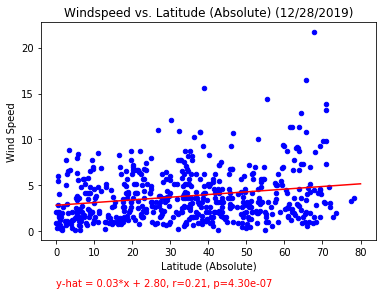

In [36]:
slope, int, r_val, p_val, se = stats.linregress(weather['Lat AbsVal'], weather['Windspeed'])
weather.plot.scatter(x='Lat AbsVal', y='Windspeed', color='Blue',
                     title=f"Windspeed vs. Latitude (Absolute) ({extract_date_str})")
x = [0, 80]
y = [int + slope * n for n in x] 
plt.plot(x, y, color='Red')
plt.xlabel('Latitude (Absolute)')
plt.ylabel('Wind Speed')
plt.text(0, -6, f"y-hat = {slope:0.2f}*x + {int:0.2f}, r={r_val:0.2f}, p={p_val:0.2e}", color="Red")
plt.savefig('Wind-vs-lat-abs.png', dpi=100)
plt.show()

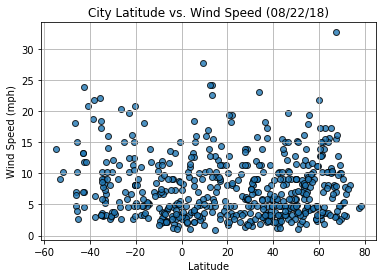